# Answering Advanced Business Questions

Imports libraries for data analysis (pandas, numpy), visualization (seaborn, matplotlib), and clustering (sklearn).

Sets the style for clean visualizations.

Loads BigQuery credentials from a JSON file to connect securely to Google Cloud.

Initializes the BigQuery client to run SQL queries from Python.

In [1]:

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from google.cloud import bigquery
sns.set(style='whitegrid')


os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../notebook-public-key.json"
client = bigquery.Client()

##  Customer Purchase Patterns

In [2]:

query_q1 = '''
SELECT
  fullVisitorId,
  DATE_TRUNC(session_date, MONTH) AS month,
  SUM(revenue_usd) AS monthly_revenue
FROM `ey-fabernovel-use-case.analytics_star_schema.fact_sessions`
WHERE revenue_usd > 0
GROUP BY fullVisitorId, month
'''
df_q1 = client.query(query_q1).to_dataframe()
df_q1['month'] = pd.to_datetime(df_q1['month'])

c:\Users\abdel\Documents\EY Fabernovel use case\venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [3]:
top_revenue = df_q1.groupby("fullVisitorId")["monthly_revenue"].sum().nlargest(5).reset_index()
top_customers = df_q1.groupby('fullVisitorId')['monthly_revenue'].sum().nlargest(5).index.tolist()
df_top = df_q1[df_q1['fullVisitorId'].isin(top_customers)].copy()
alias_map = {cid: f'Customer {i+1}' for i, cid in enumerate(top_customers)}
df_top['alias'] = df_top['fullVisitorId'].map(alias_map)

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\3325020618.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_revenue, x="monthly_revenue", y="fullVisitorId", palette="Blues_d")


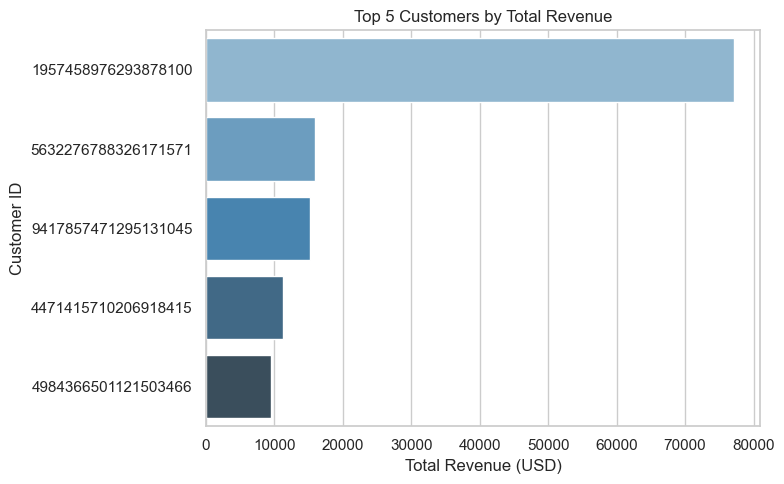

In [4]:
plt.figure(figsize=(8, 5))
sns.barplot(data=top_revenue, x="monthly_revenue", y="fullVisitorId", palette="Blues_d")
plt.title("Top 5 Customers by Total Revenue")
plt.xlabel("Total Revenue (USD)")
plt.ylabel("Customer ID")
plt.tight_layout()
plt.show()

### Monthly Revenue Trend – Top 5 Customers (Line Chart)

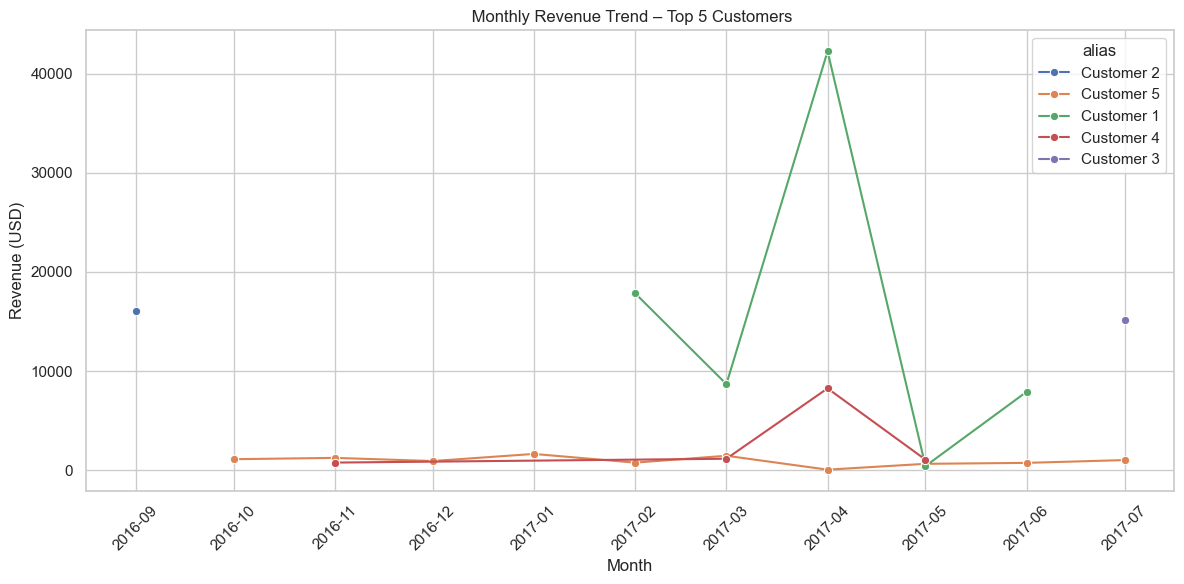

In [5]:

plt.figure(figsize=(12,6))
sns.lineplot(data=df_top, x="month", y="monthly_revenue", hue="alias", marker="o")
plt.title(" Monthly Revenue Trend – Top 5 Customers")
plt.xlabel("Month")
plt.ylabel("Revenue (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### This chart illustrates the monthly revenue generated by each of the top 5 customers over the full observation period.



- Customer 1 displays extremely high revenue in specific months, particularly April 2017 (~$42K), suggesting occasional but significant transactions

- Customers 2, 3, 4, and 5 show limited and sporadic activity, each with fewer active months.

- Most customers have short engagement windows, with few returning across multiple months.

### Revenue Distribution per Customer (Boxplot)

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\4076633414.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top, x="alias", y="monthly_revenue", palette="Set2")


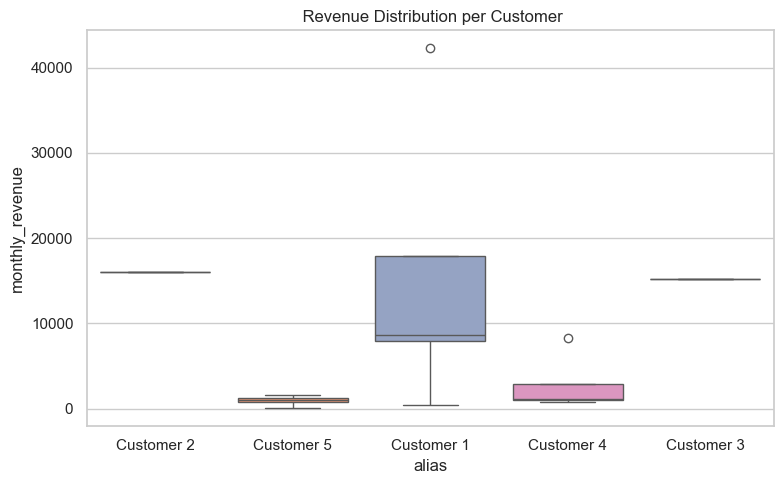

In [6]:
# 🧪 Code block explanation needed here.
plt.figure(figsize=(8,5))
sns.boxplot(data=df_top, x="alias", y="monthly_revenue", palette="Set2")
plt.title(" Revenue Distribution per Customer")
plt.tight_layout()
plt.show()

#### This plot presents the spread and consistency of monthly revenue per customer


- Customer 1 again stands out with high variability and outliers, reinforcing their unpredictable, high-impact behavior

- Customers 2 and 3 made purchases in only one month, reflected as flat lines

- Customers 4 and 5 show more consistency, with moderate but repeat purchases

## Total Revenue per Customer (Bar Chart)

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\995473876.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=total_rev, x="alias", y="monthly_revenue", palette="Blues_d")


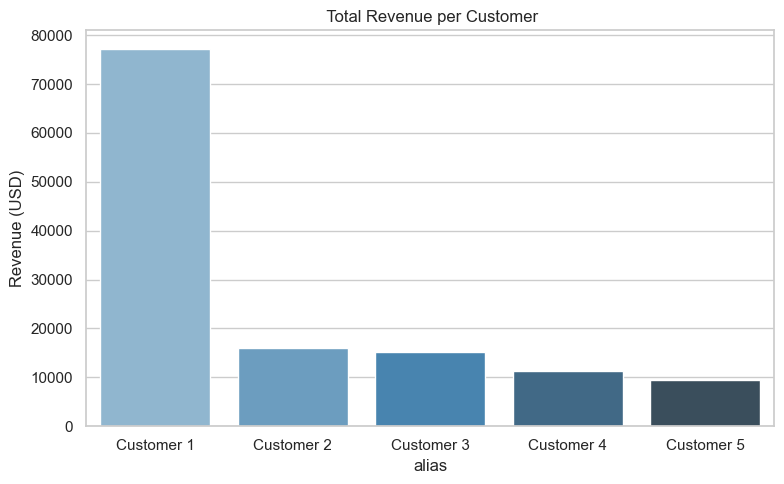

In [7]:

total_rev = df_top.groupby("alias")["monthly_revenue"].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=total_rev, x="alias", y="monthly_revenue", palette="Blues_d")
plt.title(" Total Revenue per Customer")
plt.ylabel("Revenue (USD)")
plt.tight_layout()
plt.show()

#### This bar chart compares the total revenue generated by each top customer over the full period.


- Customer 1 alone contributes over 50% of the revenue among the top 5.

- Remaining customers are relatively balanced but far lower in total value (~$10K–16K each).

- This indicates a high concentration risk, as business performance is heavily dependent on one individual.

## Monthly Revenue Heatmap

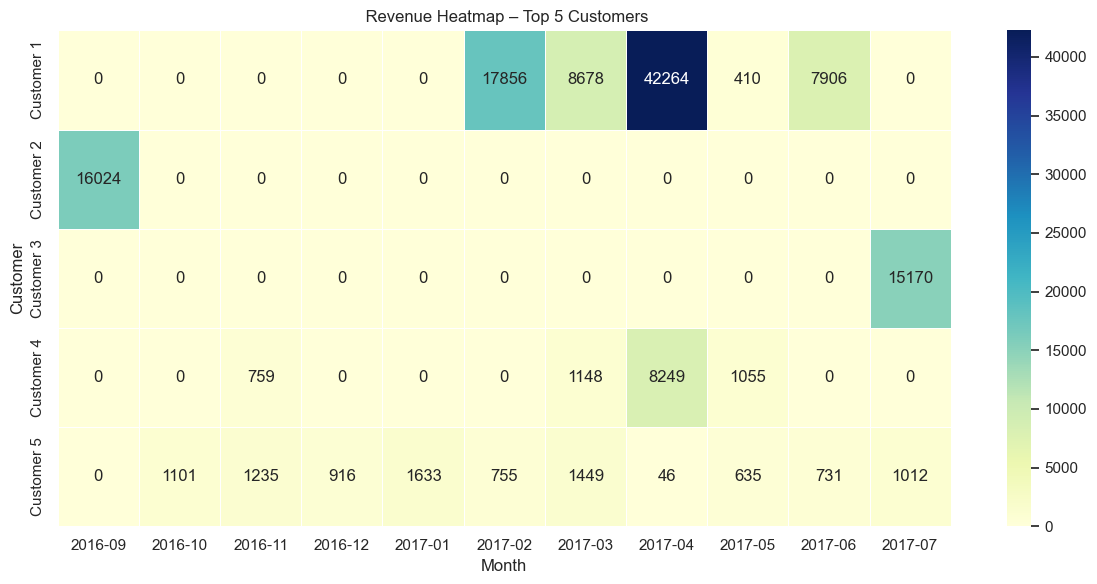

In [8]:

df_top["month_str"] = df_top["month"].dt.strftime("%Y-%m")
pivot = df_top.pivot(index="alias", columns="month_str", values="monthly_revenue").fillna(0)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title(" Revenue Heatmap – Top 5 Customers")
plt.xlabel("Month")
plt.ylabel("Customer")
plt.tight_layout()
plt.show()

#### This matrix shows when each customer made purchases and the associated monthly revenue.


- Customer 1 has multiple high-revenue months, while others only show activity in isolated months

- Customer 5 appears to be the most consistently engaged, albeit with lower revenue amounts

- There is no clear seasonal pattern, but engagement tends to be concentrated in spring and summer

## Product Performance Analysis


In [9]:

query_q2 = """
SELECT
  product_title,
  category,
  COUNT(DISTINCT CONCAT(CAST(fullVisitorId AS STRING), CAST(session_date AS STRING))) AS session_count,
  ROUND(SUM(revenue_usd), 2) AS total_revenue_usd,
  ROUND(AVG(revenue_usd), 2) AS avg_revenue_usd
FROM `ey-fabernovel-use-case.analytics_star_schema.session_products`
WHERE product_title IS NOT NULL AND revenue_usd IS NOT NULL
GROUP BY product_title, category
ORDER BY total_revenue_usd DESC
LIMIT 10
"""
df_products = client.query(query_q2).to_dataframe()
df_products.head()

c:\Users\abdel\Documents\EY Fabernovel use case\venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,product_title,category,session_count,total_revenue_usd,avg_revenue_usd
0,WD 2TB Elements Portable External Hard Drive -...,electronics,142,28903.58,203.55
1,Lock and Love Women's Removable Hooded Faux Le...,women's clothing,159,25725.11,161.79
2,Samsung 49-Inch CHG90 144Hz Curved Gaming Moni...,electronics,179,24165.25,131.33
3,Solid Gold Petite Micropave,jewelery,169,23474.61,138.90
4,Opna Women's Short Sleeve Moisture,women's clothing,176,23313.30,131.71


## Top Products by Total Revenue

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\302690855.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_products, x='total_revenue_usd', y='product_title', palette='YlGnBu')


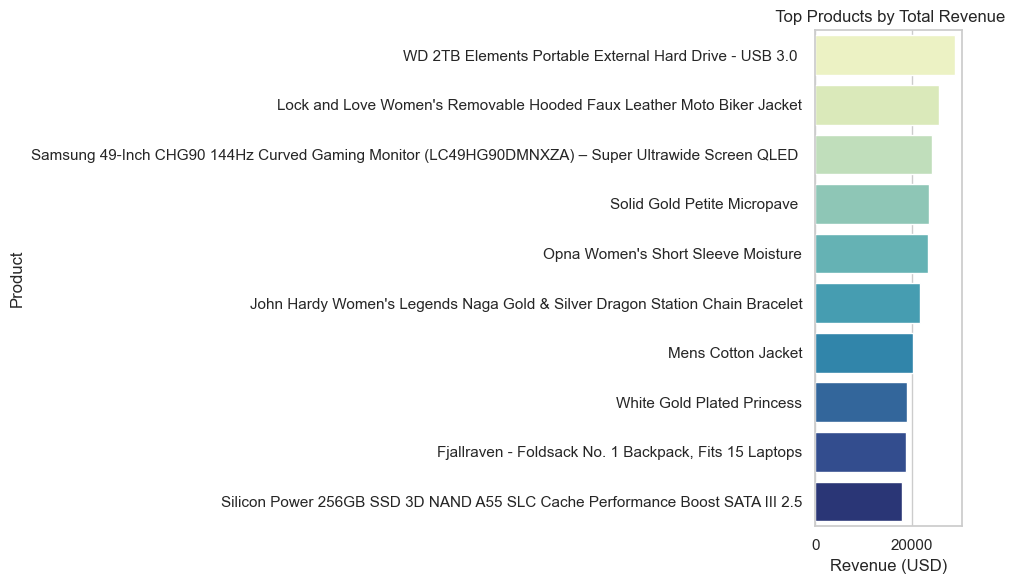

In [10]:

plt.figure(figsize=(10, 6))
sns.barplot(data=df_products, x='total_revenue_usd', y='product_title', palette='YlGnBu')
plt.title(' Top Products by Total Revenue')
plt.xlabel('Revenue (USD)')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

This bar chart displays the top 10 products based on the total revenue they have generated. The standout product is

- WD 2TB Elements Portable External Hard Drive, which leads in terms of revenue

Products like Fjallraven Backpack, Samsung Ultrawide Monitor, and John Hardy Bracelet also perform well, indicating high demand or higher unit price points. These insights help identify revenue drivers, which is key for inventory, promotion, or bundling strategies

## Most Viewed Products (Session Count)

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\3359867863.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_products, x='session_count', y='product_title', palette='Blues_d')


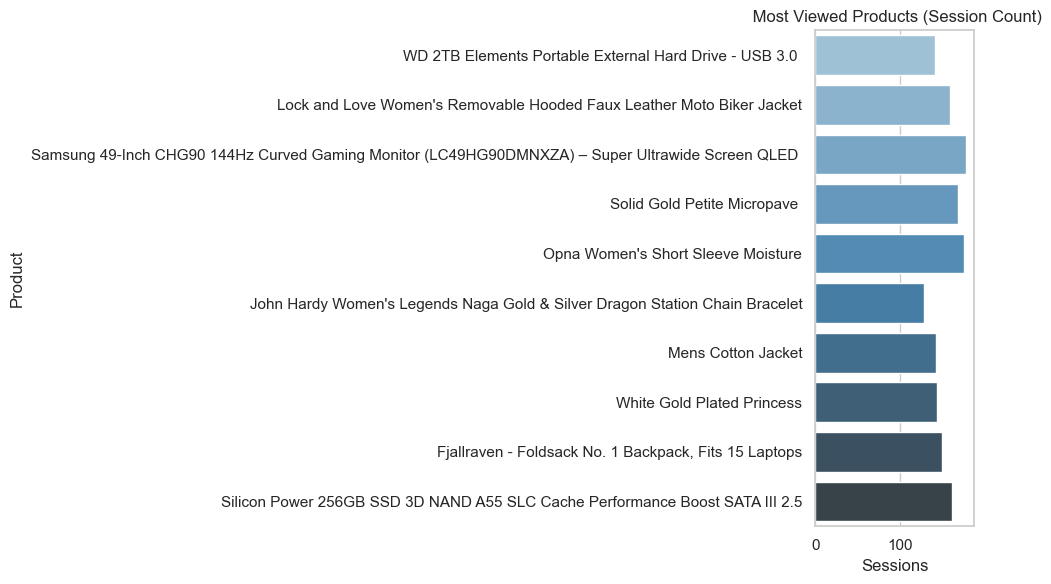

In [11]:

plt.figure(figsize=(10, 6))
sns.barplot(data=df_products, x='session_count', y='product_title', palette='Blues_d')
plt.title(' Most Viewed Products (Session Count)')
plt.xlabel('Sessions')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

This visualization highlights the products that were most frequently viewed across user sessions. High session counts suggest strong interest or curiosity from customers

- Again, the WD 2TB Hard Drive and Samsung Monitor are highly viewed, suggesting both popularity and potentially high conversion rates

However, if a product appears here but not in the top revenue chart, it may indicate low conversion (many views but few purchases), which would merit further UX or pricing investigation

## Revenue vs Session Count (Bubble = Avg Revenue)

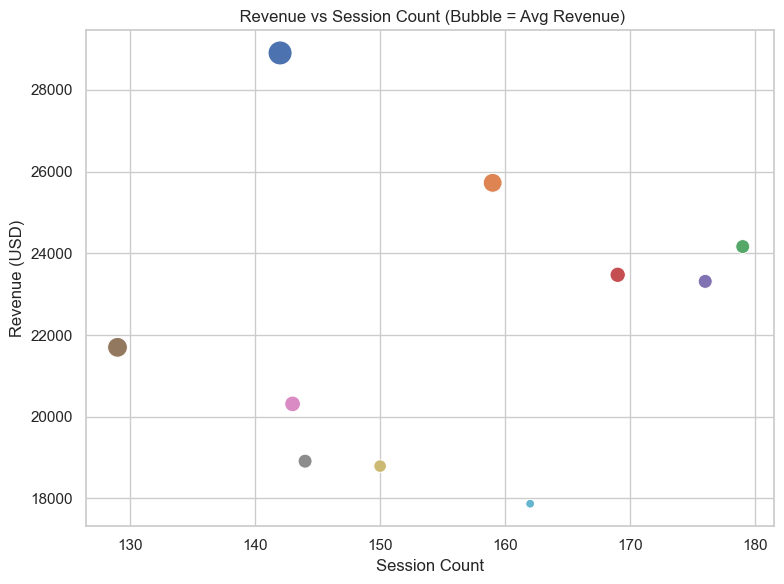

In [12]:

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_products, x='session_count', y='total_revenue_usd', size='avg_revenue_usd',
                hue='product_title', legend=False, sizes=(40, 300))
plt.title(' Revenue vs Session Count (Bubble = Avg Revenue)')
plt.xlabel('Session Count')
plt.ylabel('Revenue (USD)')
plt.tight_layout()
plt.show()

This scatter plot explores the relationship between the number of sessions and total revenue for each product. Bubble size represents the average revenue per session.


- Some products (like the top left bubble) have high revenue with relatively fewer sessions — these are high-conversion, high-ticket items.

- Other products cluster lower with many sessions but modest revenue — possibly low-price or impulse buys.

This multidimensional view is ideal for identifying high-margin products that deserve further marketing focus.

## Avg Revenue per Session – Top Products

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\2210219571.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_products.sort_values('avg_revenue_usd', ascending=False),


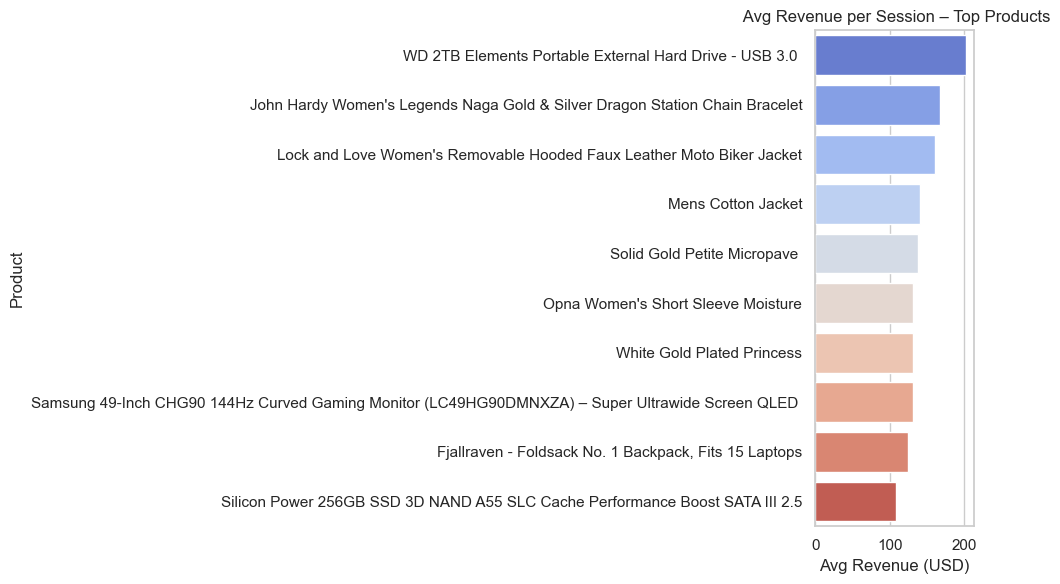

In [13]:

plt.figure(figsize=(10, 6))
sns.barplot(data=df_products.sort_values('avg_revenue_usd', ascending=False),
            x='avg_revenue_usd', y='product_title', palette='coolwarm')
plt.title(' Avg Revenue per Session – Top Products')
plt.xlabel('Avg Revenue (USD)')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

Here, products are ranked by their average revenue per session, which gives a clear view of conversion efficiency.

- WD 2TB Hard Drive and John Hardy Bracelet top the list — showing not just frequent purchases, but also high-value transactions per view.

This helps businesses identify the most profitable products relative to exposure and can support decisions like increasing ad spend on high-performing items or bundling them with complementary products.

- Top revenue generators and top viewed products often overlap but not always — high view counts don't always guarantee sales.

- By combining metrics like total revenue, session frequency, and average revenue per session, we gain a fuller picture of product performance.

- Strategic actions may include: boosting ads on high-converting items, improving descriptions for heavily viewed but poorly converting products, or adjusting pricing strategies.

## Traffic Source Effectiveness

In [14]:

query_q3 = """
SELECT
  source,
  medium,
  COUNT(DISTINCT fullVisitorId) AS total_visitors,
  COUNT(*) AS total_sessions,
  ROUND(SUM(revenue_usd), 2) AS total_revenue,
  ROUND(SUM(revenue_usd) / COUNT(*), 2) AS avg_revenue_per_session
FROM `ey-fabernovel-use-case.analytics_star_schema.fact_sessions`
WHERE revenue_usd IS NOT NULL
GROUP BY source, medium
ORDER BY total_revenue DESC
LIMIT 10
"""
traffic_df = client.query(query_q3).to_dataframe()
traffic_df["channel"] = traffic_df["source"] + " / " + traffic_df["medium"]
traffic_df.head()

c:\Users\abdel\Documents\EY Fabernovel use case\venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,source,medium,total_visitors,total_sessions,total_revenue,avg_revenue_per_session,channel
0,(direct),(none),273677,369301,1181882.13,3.20,(direct) / (none)
1,google,organic,189536,227668,202495.97,0.89,google / organic
2,dfa,cpm,3654,5671,76928.42,13.57,dfa / cpm
3,google,cpc,9869,13078,25176.76,1.93,google / cpc
4,mail.google.com,referral,771,1455,23315.95,16.02,mail.google.com / referral


## Total Revenue by Traffic Source / Medium

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\3991231020.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=traffic_df, x="total_revenue", y="channel", palette="Greens_d")


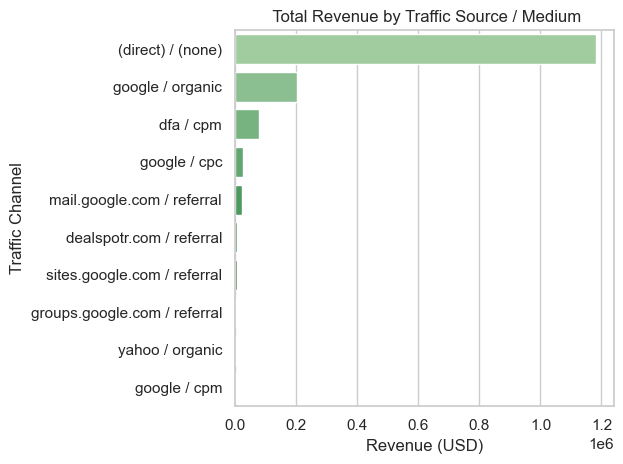

In [15]:

sns.barplot(data=traffic_df, x="total_revenue", y="channel", palette="Greens_d")
plt.title(" Total Revenue by Traffic Source / Medium")
plt.xlabel("Revenue (USD)")
plt.ylabel("Traffic Channel")
plt.tight_layout()
plt.show()

This bar chart highlights the top-performing channels by total revenue.

(direct) / (none) dominates with over $1.1 million in revenue, far surpassing other sources.

Organic search from Google is a distant second, followed by a few paid mediums like dfa / cpm and google / cpc.

### Sessions by Traffic Source / Medium

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\633143020.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=traffic_df, x="total_sessions", y="channel", palette="Blues_d")


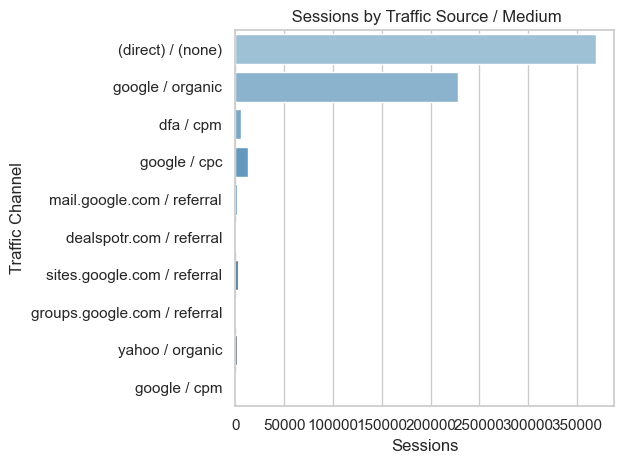

In [16]:

sns.barplot(data=traffic_df, x="total_sessions", y="channel", palette="Blues_d")
plt.title(" Sessions by Traffic Source / Medium")
plt.xlabel("Sessions")
plt.ylabel("Traffic Channel")
plt.tight_layout()
plt.show()

This chart shows the total number of sessions initiated via each channel.

Again, (direct) / (none) leads, followed closely by google / organic.

Most paid or referral sources generate significantly fewer sessions, despite their potential revenue.

### Avg Revenue per Session – Traffic Channels

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\69186199.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=traffic_df, x="avg_revenue_per_session", y="channel", palette="Purples")


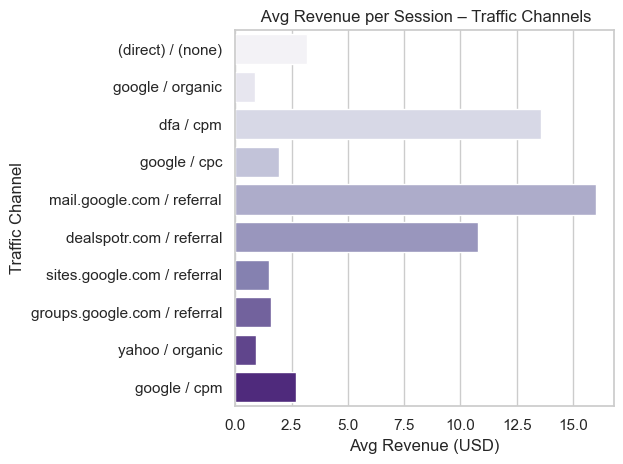

In [17]:

sns.barplot(data=traffic_df, x="avg_revenue_per_session", y="channel", palette="Purples")
plt.title(" Avg Revenue per Session – Traffic Channels")
plt.xlabel("Avg Revenue (USD)")
plt.ylabel("Traffic Channel")
plt.tight_layout()
plt.show()

Now we look at efficiency per session, revealing a very different story.

Channels like mail.google.com / referral, dealspotr.com / referral, and dfa / cpm have the highest average revenue per session (up to $15/session).

Meanwhile, (direct) and google / organic, though high in volume, yield relatively low revenue per session.

### Revenue vs. Sessions – Bubble Chart

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\3765991986.py:14: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\abdel\Documents\EY Fabernovel use case\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


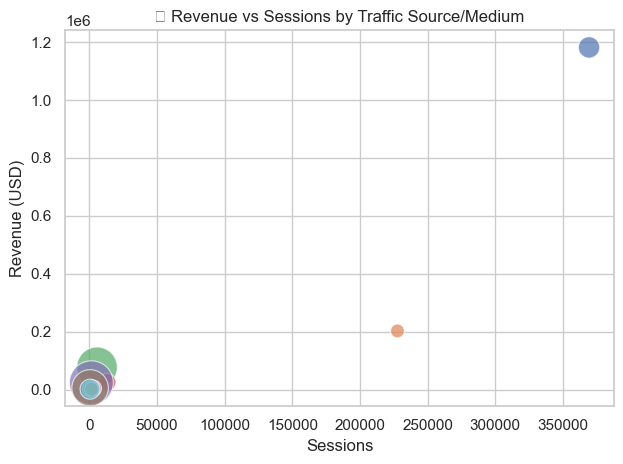

In [18]:

sns.scatterplot(
    data=traffic_df,
    x="total_sessions",
    y="total_revenue",
    size="avg_revenue_per_session",
    hue="channel",
    sizes=(100, 1000),
    legend=False,
    alpha=0.7
)
plt.title("🔍 Revenue vs Sessions by Traffic Source/Medium")
plt.xlabel("Sessions")
plt.ylabel("Revenue (USD)")
plt.tight_layout()
plt.show()

This visualization combines all the metrics above:

The x-axis = sessions, y-axis = revenue, and bubble size = average revenue per session.

(direct) / (none) is a giant bubble in the top right, meaning it delivers both volume and revenue but not the highest average per session.

The top-left quadrant has channels with small session counts but big revenue per session, suggesting opportunities for focused campaigns.

# Segment Users Based on Engagement

In [19]:

query_q4 = """
SELECT
  fullVisitorId,
  COUNT(DISTINCT visitId) AS sessions,
  SUM(pageviews) AS total_pageviews,
  SUM(total_hits) AS total_hits,
  ROUND(SUM(revenue_usd), 2) AS revenue_usd
FROM `ey-fabernovel-use-case.analytics_star_schema.fact_sessions`
GROUP BY fullVisitorId
HAVING sessions > 0 AND total_hits > 0
"""
df = client.query(query_q4).to_dataframe()

c:\Users\abdel\Documents\EY Fabernovel use case\venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [20]:

df["avg_pageviews"] = df["total_pageviews"] / df["sessions"]
df["avg_hits"] = df["total_hits"] / df["sessions"]
df["revenue_usd"] = df["revenue_usd"].fillna(0)


In [21]:

df["avg_pageviews"].replace([np.inf, -np.inf], np.nan, inplace=True)
df["avg_hits"].replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=["avg_pageviews", "avg_hits"], inplace=True)

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\4024387538.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["avg_pageviews"].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\4024387538.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

In [22]:

features = ["sessions", "total_pageviews", "total_hits", "avg_pageviews", "avg_hits"]
X = StandardScaler().fit_transform(df[features])

kmeans = KMeans(n_clusters=4, random_state=42)
df["cluster"] = kmeans.fit_predict(X)

### Total Revenue by Engagement Cluster

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\2955879430.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.groupby("cluster")["revenue_usd"].sum().reset_index(),


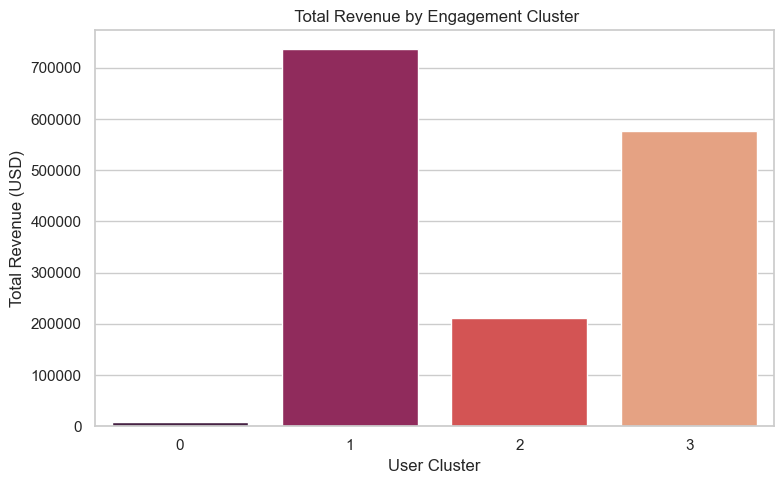

In [23]:

plt.figure(figsize=(8, 5))
sns.barplot(data=df.groupby("cluster")["revenue_usd"].sum().reset_index(),
            x="cluster", y="revenue_usd", palette="rocket")
plt.title(" Total Revenue by Engagement Cluster")
plt.xlabel("User Cluster")
plt.ylabel("Total Revenue (USD)")
plt.tight_layout()
plt.show()


This bar plot shows the total revenue (USD) generated by each user cluster, as identified using K-Means segmentation.



- Cluster 1 and Cluster 3 generate the most revenue overall.

- Cluster 0 generates the least revenue and likely represents low-engagement users.

- This implies that engagement (defined via sessions, pageviews, and hits) is positively related to purchasing.

### Revenue Distribution per Engagement Cluster

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\3558773178.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="cluster", y="revenue_usd", palette="coolwarm")


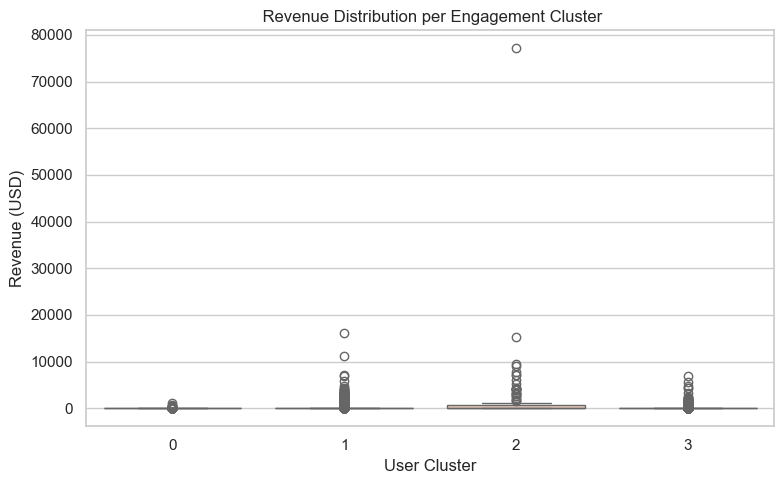

In [24]:

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="cluster", y="revenue_usd", palette="coolwarm")
plt.title(" Revenue Distribution per Engagement Cluster")
plt.xlabel("User Cluster")
plt.ylabel("Revenue (USD)")
plt.tight_layout()
plt.show()

This boxplot displays the spread of individual revenues for users in each engagement cluster.



- Revenue is right-skewed in all segments, meaning a few high-spending users push up totals.

- Cluster 1 and Cluster 3 again show broader and higher revenue distributions.

- Cluster 2 has many mid-range contributors, suggesting moderate engagement may still lead to consistent purchasing behavior.

### Engagement Metrics per Cluster

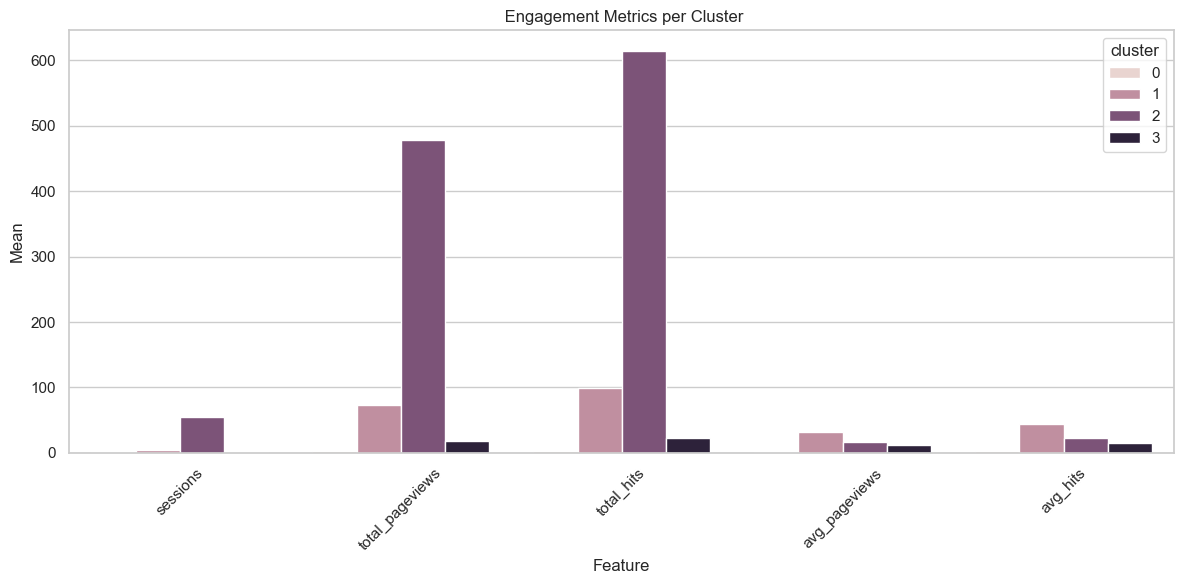

In [25]:

cluster_summary = df.groupby("cluster")[features].mean().reset_index()
melted_summary = cluster_summary.melt(id_vars="cluster", var_name="Feature", value_name="Mean")

plt.figure(figsize=(12, 6))
sns.barplot(data=melted_summary, x="Feature", y="Mean", hue="cluster")
plt.title(" Engagement Metrics per Cluster")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This bar plot breaks down the average values of engagement metrics per cluster



- Cluster 2 dominates every engagement metric, showing very high levels of interaction.

- Yet Cluster 1, while slightly lower in engagement, generates more revenue, possibly due to more targeted or higher-intent sessions.

- Cluster 0 shows extremely low engagement across all metrics — very likely casual or one-time visitors.

### Correlation Heatmap – Engagement vs Revenue

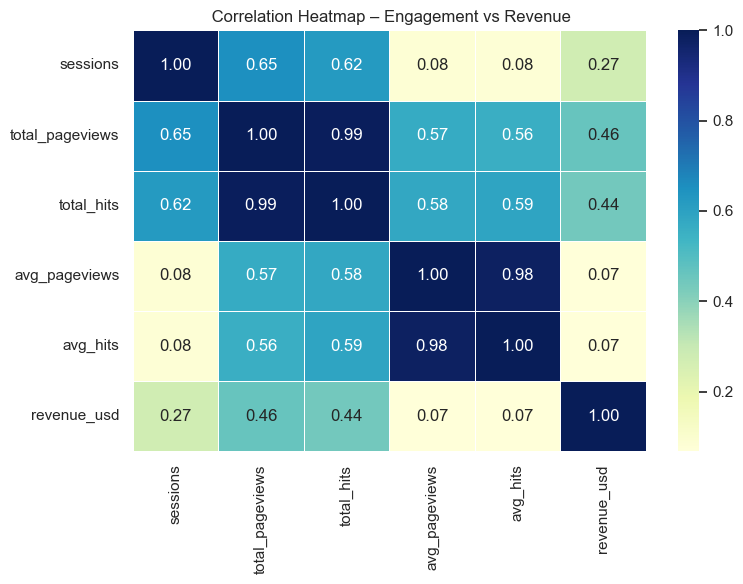

In [26]:

plt.figure(figsize=(8, 6))
corr = df[features + ["revenue_usd"]].corr()
sns.heatmap(corr, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title(" Correlation Heatmap – Engagement vs Revenue")
plt.tight_layout()
plt.show()

This heatmap shows the correlation between engagement metrics and revenue.



- total_pageviews and total_hits show moderate positive correlation with revenue (around 0.44–0.46).

- Surprisingly, avg_pageviews and avg_hits correlate very weakly with revenue (<0.1), implying that volume of engagement (not just depth per session) is more important.

- sessions has a small but noticeable impact on revenue.

# Churn Rate Analysis

In [27]:
query_q5_reload = """
SELECT
  fullVisitorId,
  session_date,
  pageviews,
  total_hits,
  ROUND(SUM(revenue_usd), 2) AS revenue_usd
FROM `ey-fabernovel-use-case.analytics_star_schema.fact_sessions`
GROUP BY fullVisitorId, session_date, pageviews, total_hits
"""

df = client.query(query_q5_reload).to_dataframe()

c:\Users\abdel\Documents\EY Fabernovel use case\venv\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [28]:
df["session_date"] = pd.to_datetime(df["session_date"])


user_last = df.groupby("fullVisitorId")["session_date"].max().reset_index()
user_last.columns = ["fullVisitorId", "last_session"]


latest_date = df["session_date"].max()
user_last["days_since_last"] = (latest_date - user_last["last_session"]).dt.days
user_last["churned"] = (user_last["days_since_last"] > 60).astype(int)
user_last["churn_month"] = user_last["last_session"].dt.to_period("M").dt.to_timestamp()

In [29]:
monthly_churn = user_last.groupby("churn_month").agg(
    churned_users=("churned", "sum"),
    total_users=("fullVisitorId", "count")
).reset_index()
monthly_churn["churn_rate"] = monthly_churn["churned_users"] / monthly_churn["total_users"]


df_user = df.merge(user_last[["fullVisitorId", "churned"]], on="fullVisitorId", how="left")


df_user["pageviews"] = pd.to_numeric(df_user["pageviews"], errors="coerce")
df_user["revenue_usd"] = pd.to_numeric(df_user["revenue_usd"], errors="coerce")

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\91649825.py:7: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\abdel\Documents\EY Fabernovel use case\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


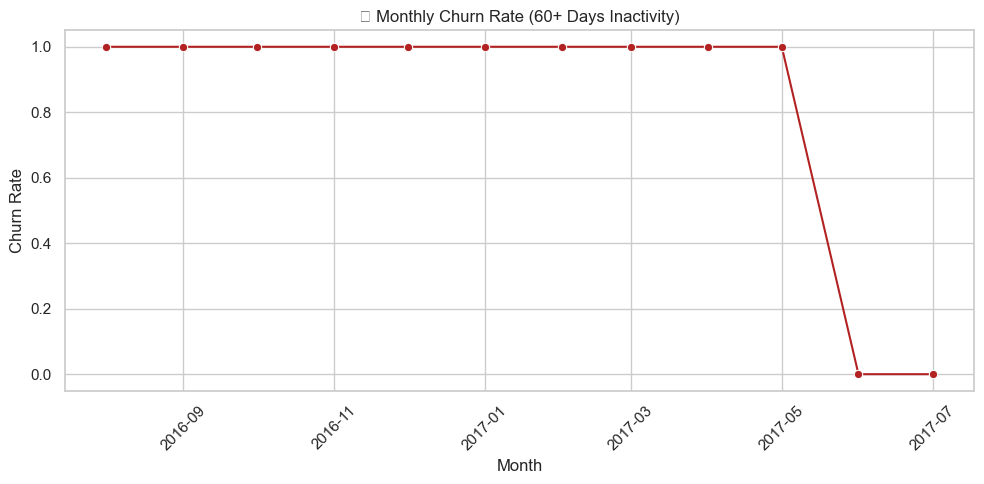

In [30]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_churn, x="churn_month", y="churn_rate", marker="o", color="firebrick")
plt.title("📉 Monthly Churn Rate (60+ Days Inactivity)")
plt.xlabel("Month")
plt.ylabel("Churn Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This line chart displays the churn rate per month, calculated based on users who had no activity for at least 60 days after their last session in that month.



- From August 2016 to May 2017, churn rate remained consistently high (~100%), suggesting limited returning activity from users.

- A sharp drop to 0% in June and July 2017 is most likely a data cutoff issue (we don’t have enough time afterward to measure churn yet), not a real improvement.

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\2495736745.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=user_last, x="churned", palette="Set2")
C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\2495736745.py:7: UserWarning: Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\abdel\Documents\EY Fabernovel use case\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


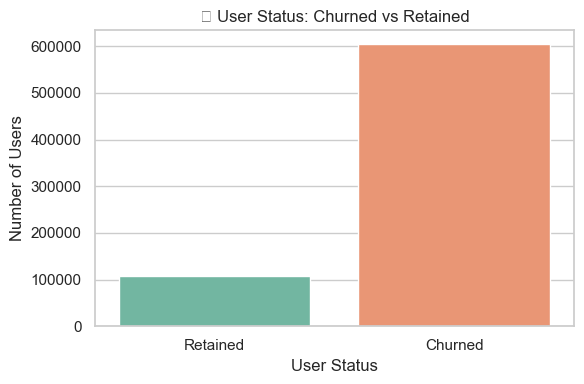

In [31]:
plt.figure(figsize=(6, 4))
sns.countplot(data=user_last, x="churned", palette="Set2")
plt.title("👤 User Status: Churned vs Retained")
plt.xlabel("User Status")
plt.ylabel("Number of Users")
plt.xticks([0, 1], ["Retained", "Churned"])
plt.tight_layout()
plt.show()

A bar chart comparing the number of churned vs retained users.



- Over 600,000 users churned, while only around 100,000 were retained.

- That’s an 85%+ churn rate, confirming the retention challenge.

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\1817392684.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=revenue_stats, x="churned", y="revenue_usd", palette="Blues")
C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\1817392684.py:8: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\abdel\Documents\EY Fabernovel use case\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


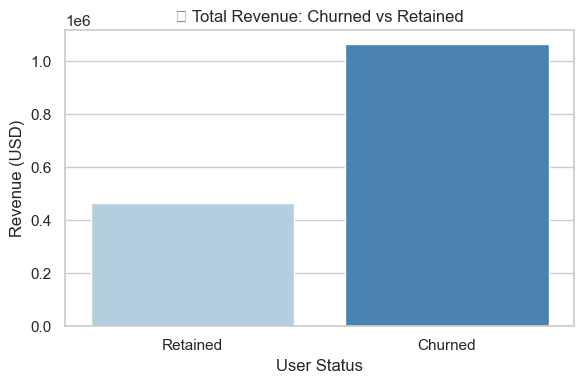

In [32]:
revenue_stats = df_user.groupby("churned")["revenue_usd"].sum().reset_index()
plt.figure(figsize=(6, 4))
sns.barplot(data=revenue_stats, x="churned", y="revenue_usd", palette="Blues")
plt.title("💰 Total Revenue: Churned vs Retained")
plt.xlabel("User Status")
plt.ylabel("Revenue (USD)")
plt.xticks([0, 1], ["Retained", "Churned"])
plt.tight_layout()
plt.show()

This chart compares the total revenue generated by each group.


- Churned users account for more than double the revenue of retained users.

- This suggests many valuable customers are not returning, amplifying the business risk of churn.



C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\1941256503.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_user, x="churned", y="pageviews", palette="coolwarm")
C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\1941256503.py:7: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\abdel\Documents\EY Fabernovel use case\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


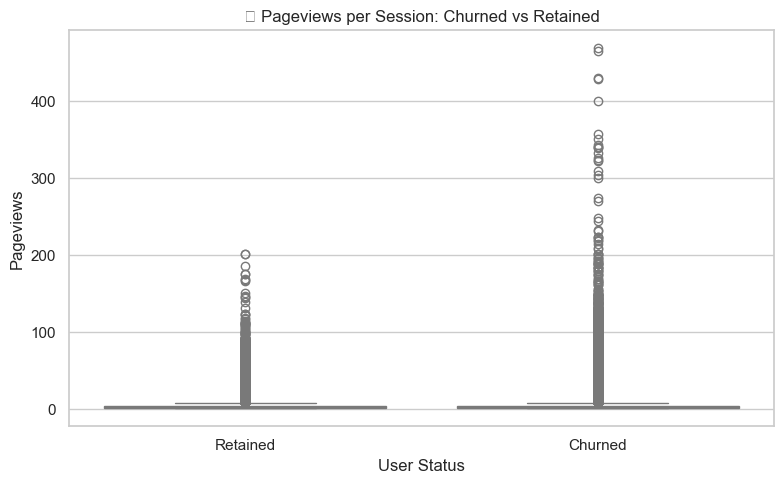

In [33]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_user, x="churned", y="pageviews", palette="coolwarm")
plt.title("📄 Pageviews per Session: Churned vs Retained")
plt.xlabel("User Status")
plt.ylabel("Pageviews")
plt.xticks([0, 1], ["Retained", "Churned"])
plt.tight_layout()
plt.show()

Boxplot comparing session pageviews between churned and retained users.



- While medians are low for both, churned users show higher outliers, meaning some users were heavily engaged before disappearing.

- Indicates that engagement alone doesn’t guarantee retention.

C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\4193860380.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_user, x="churned", y="revenue_usd", palette="YlGnBu")
C:\Users\abdel\AppData\Local\Temp\ipykernel_28936\4193860380.py:7: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\abdel\Documents\EY Fabernovel use case\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


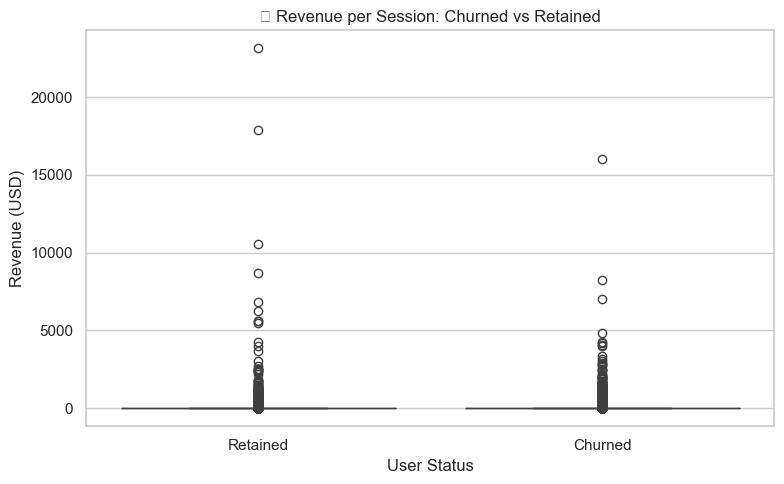

In [34]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_user, x="churned", y="revenue_usd", palette="YlGnBu")
plt.title("💸 Revenue per Session: Churned vs Retained")
plt.xlabel("User Status")
plt.ylabel("Revenue (USD)")
plt.xticks([0, 1], ["Retained", "Churned"])
plt.tight_layout()
plt.show()

Boxplot showing per-session revenue for each user group.



- Most sessions generate very little revenue.

- However, churned users again include high-revenue outliers.

### Our analysis revealed a consistently high churn rate across the past year, with over 85% of users ceasing activity. Alarmingly, these churned users not only represent the majority of the user base but also  contributed more than half of the total revenue. This indicates that the platform is losing not just users, but some of its most valuable customers.

### Engagement metrics such as pageviews and per-session revenue show that even highly engaged users can churn, suggesting that retention is influenced by more than just usage volume. Factors such as &post-purchase satisfaction, support quality, or product relevance could be key drivers.